# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [332]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [333]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [334]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [335]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-05-12 20:40:01.867564
metric: deaths at 2020-05-12 20:40:04.530201
Latest data from 2020-05-12


In [336]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [337]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-12              US    1369376          21495   82356        1674   
1  2020-05-12  United Kingdom     227741           3409   32769         628   
2  2020-05-12           Italy     221216           1402   30911         172   
3  2020-05-12          France     178349            802   26994         348   
4  2020-05-12           Spain     228030            594   26920         176   
5  2020-05-12          Brazil     178214           8620   12461         808   
6  2020-05-12         Belgium      53779            330    8761          54   
7  2020-05-12         Germany     173171            595    7738          77   
8  2020-05-12            Iran     110767           1481    6733          48   
9  2020-05-12     Netherlands      43183            196    5529          54   
10 2020-05-12          Canada      72419           1155    5300         185   
11 2020-05-12           China      84018              7    4637           0   
12 2020-05-12          Mexico      38324           1997    3926         353   
13 2020-05-12          Turkey     141475           1704    3894          53   
14 2020-05-12          Sweden      27272            602    3313          57   
15 2020-05-12           India      74292           3524    2415         121   
16 2020-05-12         Ecuador      30419            910    2327         182   
17 2020-05-12          Russia     232243          10899    2116         107   
18 2020-05-12            Peru      72059           3237    2057          96   
19 2020-05-12     Switzerland      30380             36    1867          22   

    mortality_rate  
0         0.060141  
1         0.143887  
2         0.139732  
3         0.151355  
4         0.118055  
5         0.069922  
6         0.162907  
7         0.044684  
8         0.060785  
9         0.128036  
10        0.073185  
11        0.055191  
12        0.102442  
13        0.027524  
14        0.121480  
15        0.032507  
16        0.076498  
17        0.009111  
18        0.028546  
19        0.061455

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [338]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-12              US    1369376          21495   82356        1674   
17 2020-05-12          Russia     232243          10899    2116         107   
5  2020-05-12          Brazil     178214           8620   12461         808   
15 2020-05-12           India      74292           3524    2415         121   
1  2020-05-12  United Kingdom     227741           3409   32769         628   
18 2020-05-12            Peru      72059           3237    2057          96   
26 2020-05-12        Pakistan      34336           2255     737          31   
12 2020-05-12          Mexico      38324           1997    3926         353   
40 2020-05-12    Saudi Arabia      42925           1911     264           9   
13 2020-05-12          Turkey     141475           1704    3894          53   

    mortality_rate  
0         0.060141  
17        0.009111  
5         0.069922  
15        0.032507  
1         0.143887  
18        0.028546  
26        0.021464  
12        0.102442  
40        0.006150  
13        0.027524

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [339]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

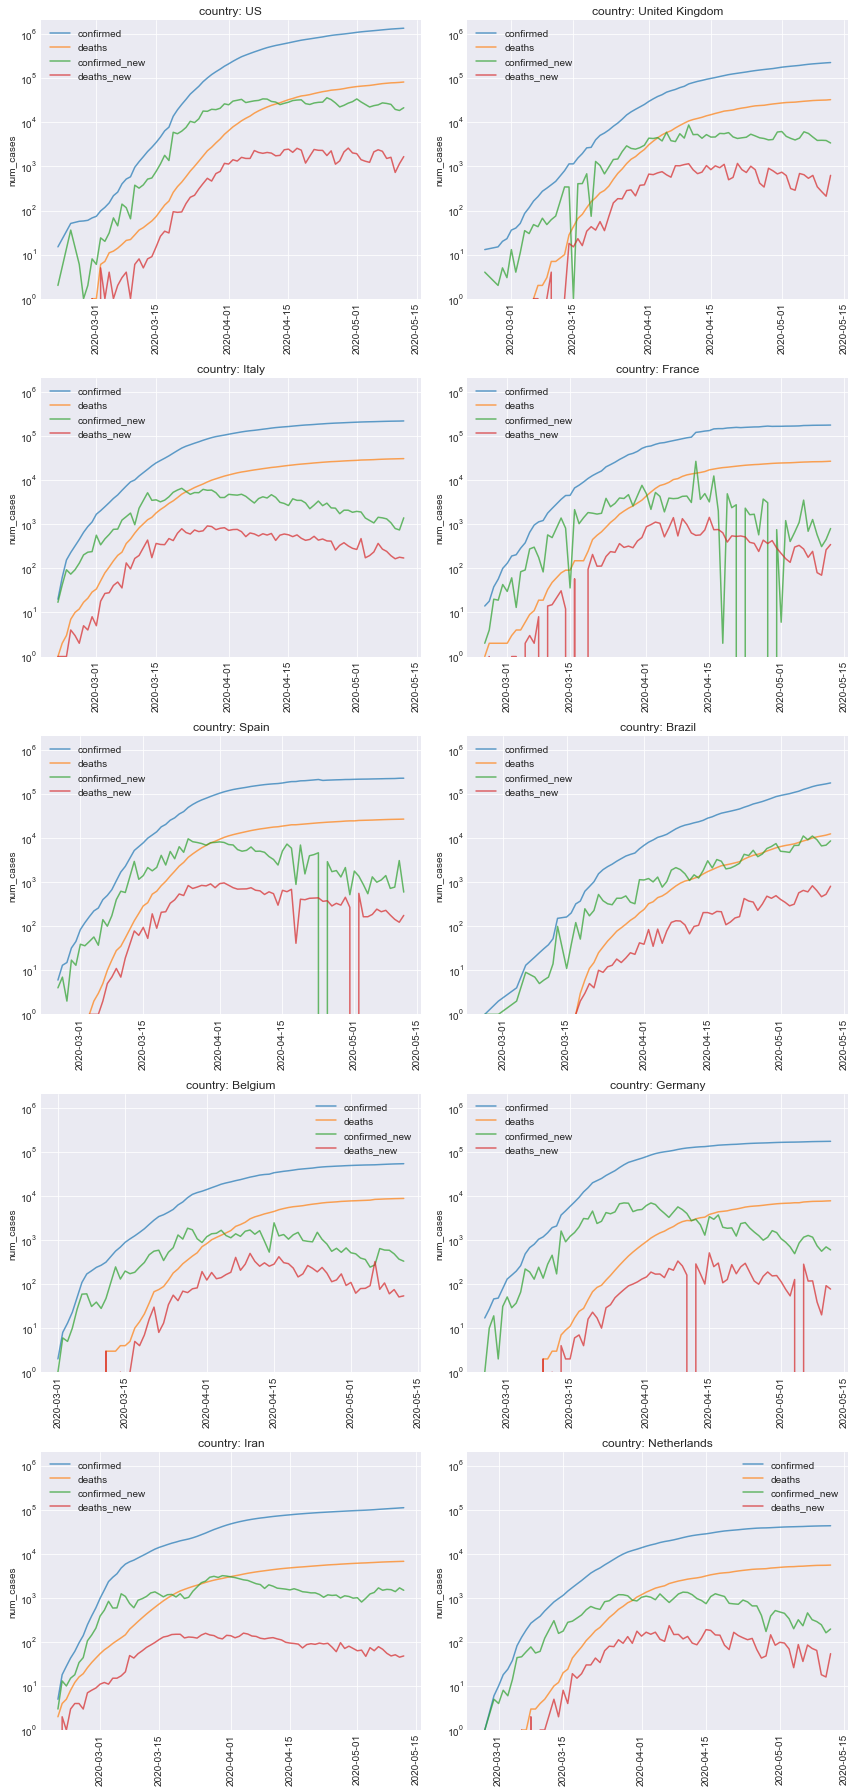

In [340]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

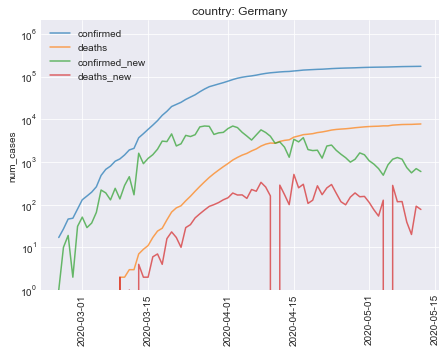

In [341]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [342]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-05-13 2020-05-19 2020-06-02  2020-05-13 2020-05-19   
country                                                                      
US                  1398991.0  1556517.0  1996537.0     83993.0    93523.0   
United Kingdom       233215.0   261938.0   343475.0     33183.0    35857.0   
Italy                222311.0   228986.0   245351.0     31158.0    32417.0   
Spain                229269.0   237428.0   257610.0     27128.0    28220.0   
France               179108.0   183187.0   193070.0     27060.0    28184.0   
Brazil               191193.0   267809.0   587921.0     13315.0    19152.0   
Belgium               54496.0    57740.0    66080.0      8856.0     9307.0   
Germany              174275.0   179290.0   191560.0      7816.0     8271.0   
Iran                 112407.0   122493.0   149686.0      6793.0     7119.0   
Netherlands           43571.0    45268.0    49488.0      5596.0     5904.0   

                          mortality_rate_pred                        \
date           2020-06-02          2020-05-13 2020-05-19 2020-06-02   
country                                                               
US               120180.0            0.060038   0.060085   0.060194   
United Kingdom    42967.0            0.142285   0.136891   0.125095   
Italy             35555.0            0.140155   0.141568   0.144915   
Spain             30941.0            0.118324   0.118857   0.120108   
France            30991.0            0.151082   0.153854   0.160517   
Brazil            44727.0            0.069642   0.071514   0.076077   
Belgium           10452.0            0.162507   0.161188   0.158172   
Germany            9440.0            0.044849   0.046132   0.049280   
Iran               7944.0            0.060432   0.058118   0.053071   
Netherlands        6689.0            0.128434   0.130423   0.135164   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.017942             0.018074  
United Kingdom                0.019546             0.013004  
Italy                         0.004943             0.006622  
Spain                         0.005844             0.006596  
France                        0.003760             0.006805  
Brazil                        0.057773             0.062456  
Belgium                       0.009684             0.008322  
Germany                       0.004739             0.009488  
Iran                          0.014424             0.007859  
Netherlands                   0.006386             0.008961

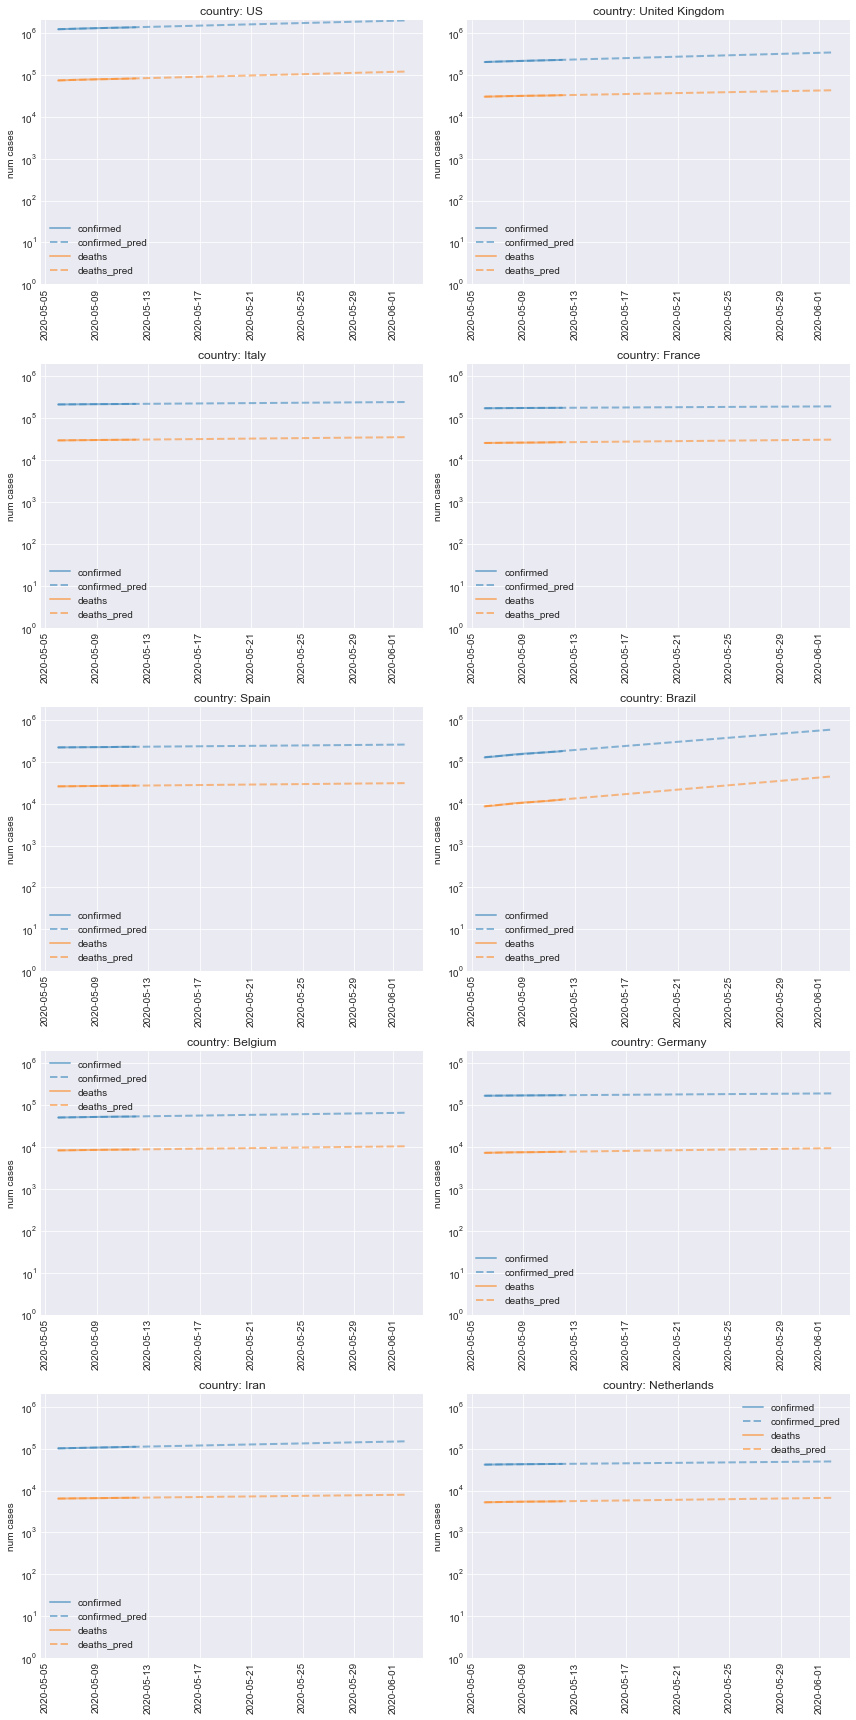

In [343]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [344]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-12_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [345]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


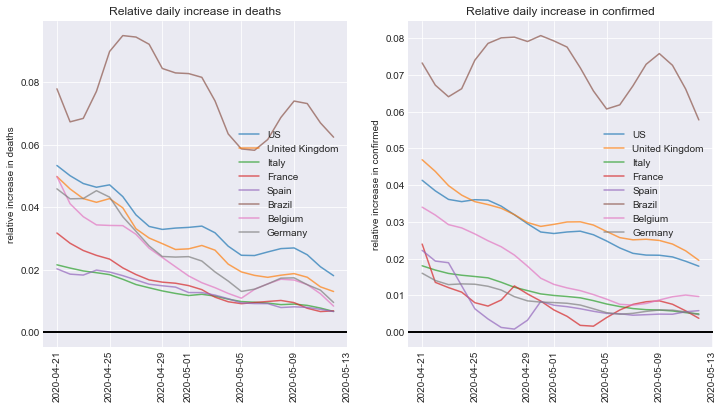

In [346]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-05-13 2020-05-19  2020-05-13 2020-05-19   
country                                                           
US                  1417216.0  1607221.0     85621.0    98499.0   
United Kingdom       237351.0   274074.0     33686.0    37292.0   
Italy                223460.0   231924.0     31393.0    33053.0   
Spain                228752.0   235985.0     27289.0    28645.0   
France               180265.0   186837.0     27230.0    28659.0   
Brazil               195453.0   285780.0     13369.0    19476.0   
Belgium               54341.0    57282.0      8988.0     9716.0   
Germany              174631.0   180308.0      7933.0     8627.0   
Iran                 111813.0   121034.0      6836.0     7240.0   
Netherlands           43810.0    45876.0      5664.0     6084.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-05-13 2020-05-19                           
country                                                                 
US                        0.060415   0.061285                0.021190   
United Kingdom            0.141925   0.136065                0.024266   
Italy                     0.140486   0.142517                0.006215   
Spain                     0.119295   0.121385                0.005202   
France                    0.151055   0.153390                0.005986   
Brazil                    0.068400   0.068150                0.065365   
Belgium                   0.165400   0.169617                0.008823   
Germany                   0.045427   0.047846                0.005346   
Iran                      0.061138   0.059818                0.013295   
Netherlands               0.129286   0.132618                0.007707   

               frac_increase_deaths  
date                                 
country                              
US                         0.023627  
United Kingdom             0.017095  
Italy                      0.008630  
Spain                      0.008120  
France                     0.008558  
Brazil                     0.064716  
Belgium                    0.013065  
Germany                    0.014069  
Iran                       0.009624  
Netherlands                0.011987

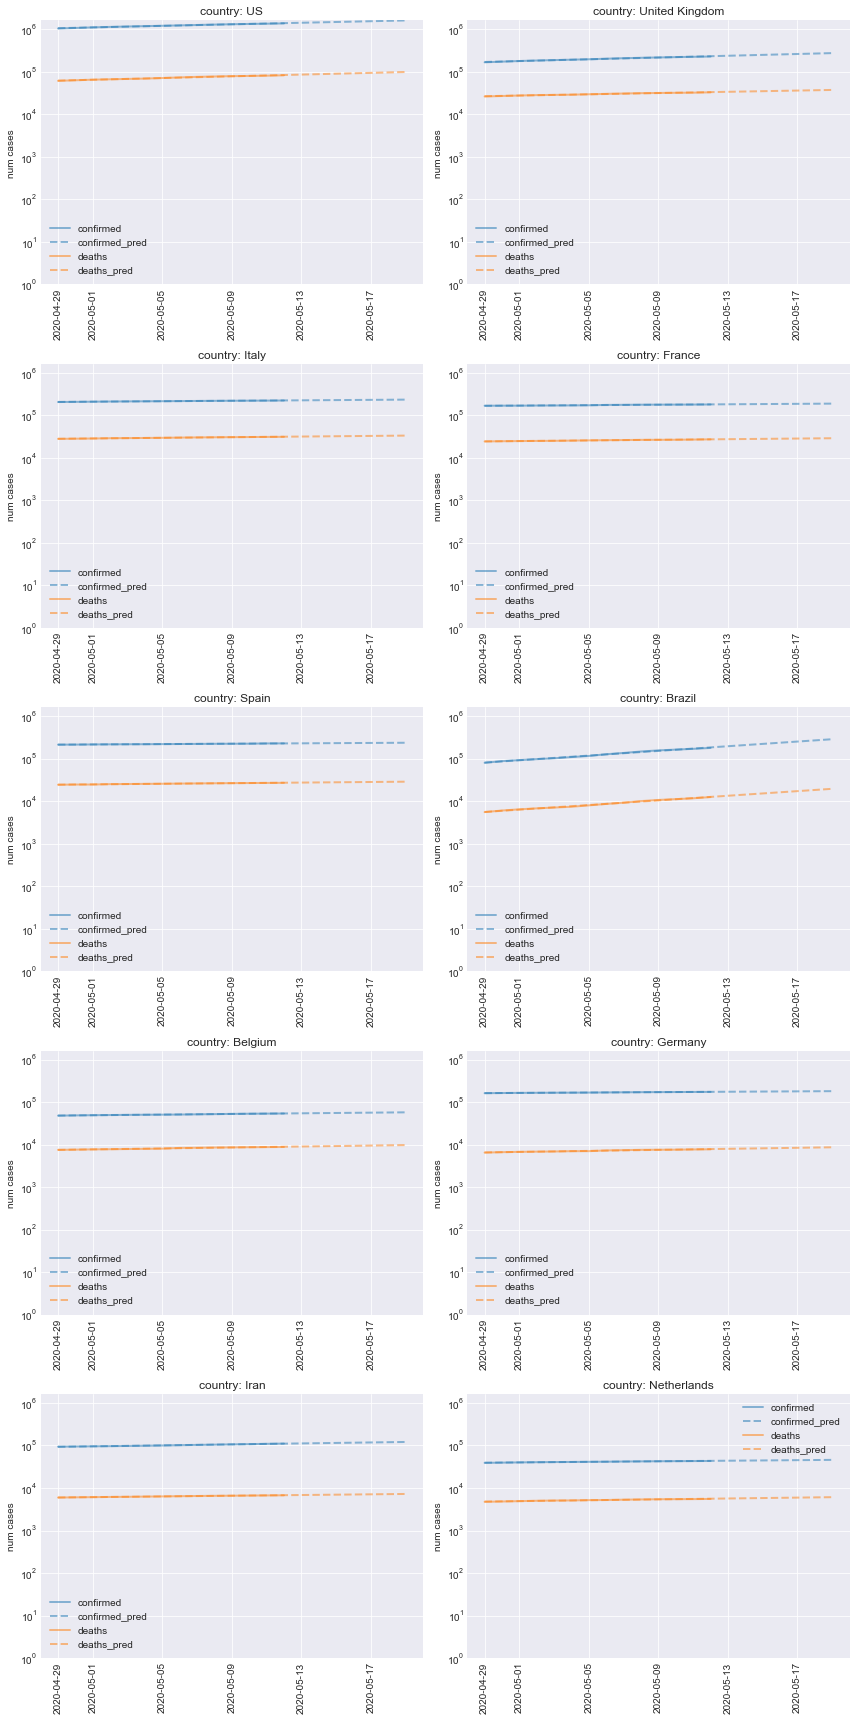

In [347]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [348]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-12_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [349]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

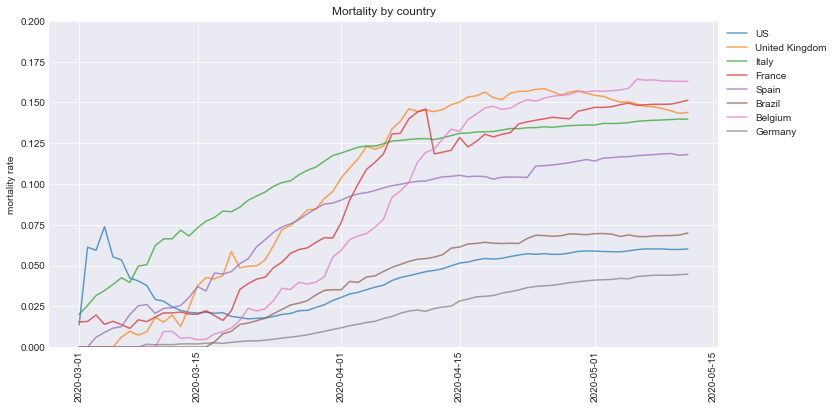

In [350]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [351]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

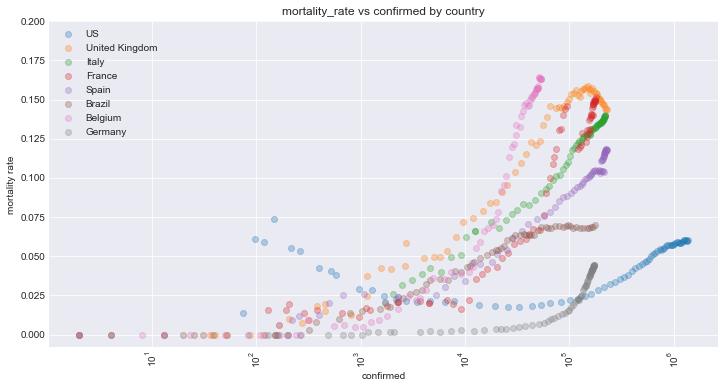

In [352]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [353]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

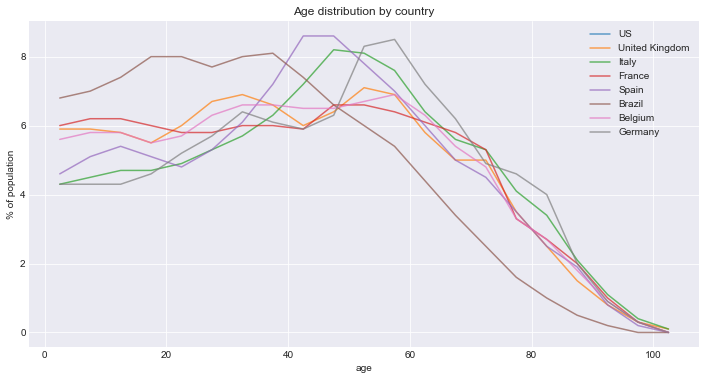

In [354]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

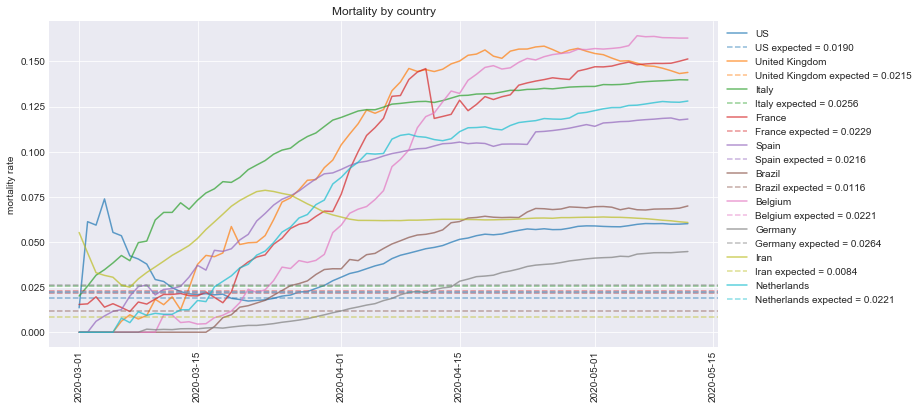

date         country  mortality_rate  confirmed   deaths
0 2020-05-12         Belgium        0.162907    53779.0   8761.0
1 2020-05-12          France        0.151355   178349.0  26994.0
2 2020-05-12  United Kingdom        0.143887   227741.0  32769.0
3 2020-05-12           Italy        0.139732   221216.0  30911.0
4 2020-05-12     Netherlands        0.128036    43183.0   5529.0
5 2020-05-12           Spain        0.118055   228030.0  26920.0
6 2020-05-12          Brazil        0.069922   178214.0  12461.0
7 2020-05-12            Iran        0.060785   110767.0   6733.0
8 2020-05-12              US        0.060141  1369376.0  82356.0
9 2020-05-12         Germany        0.044684   173171.0   7738.0

In [355]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

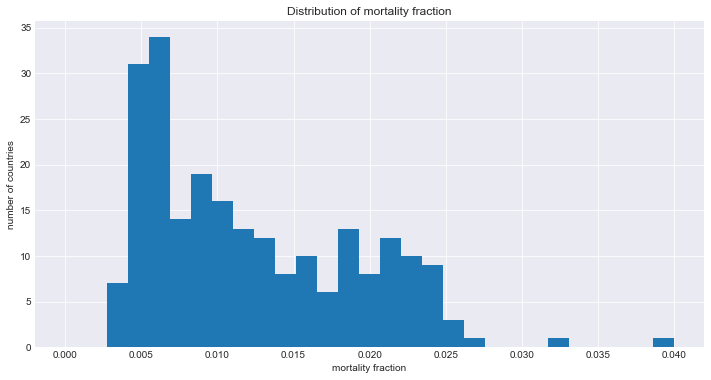

In [356]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [357]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [358]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

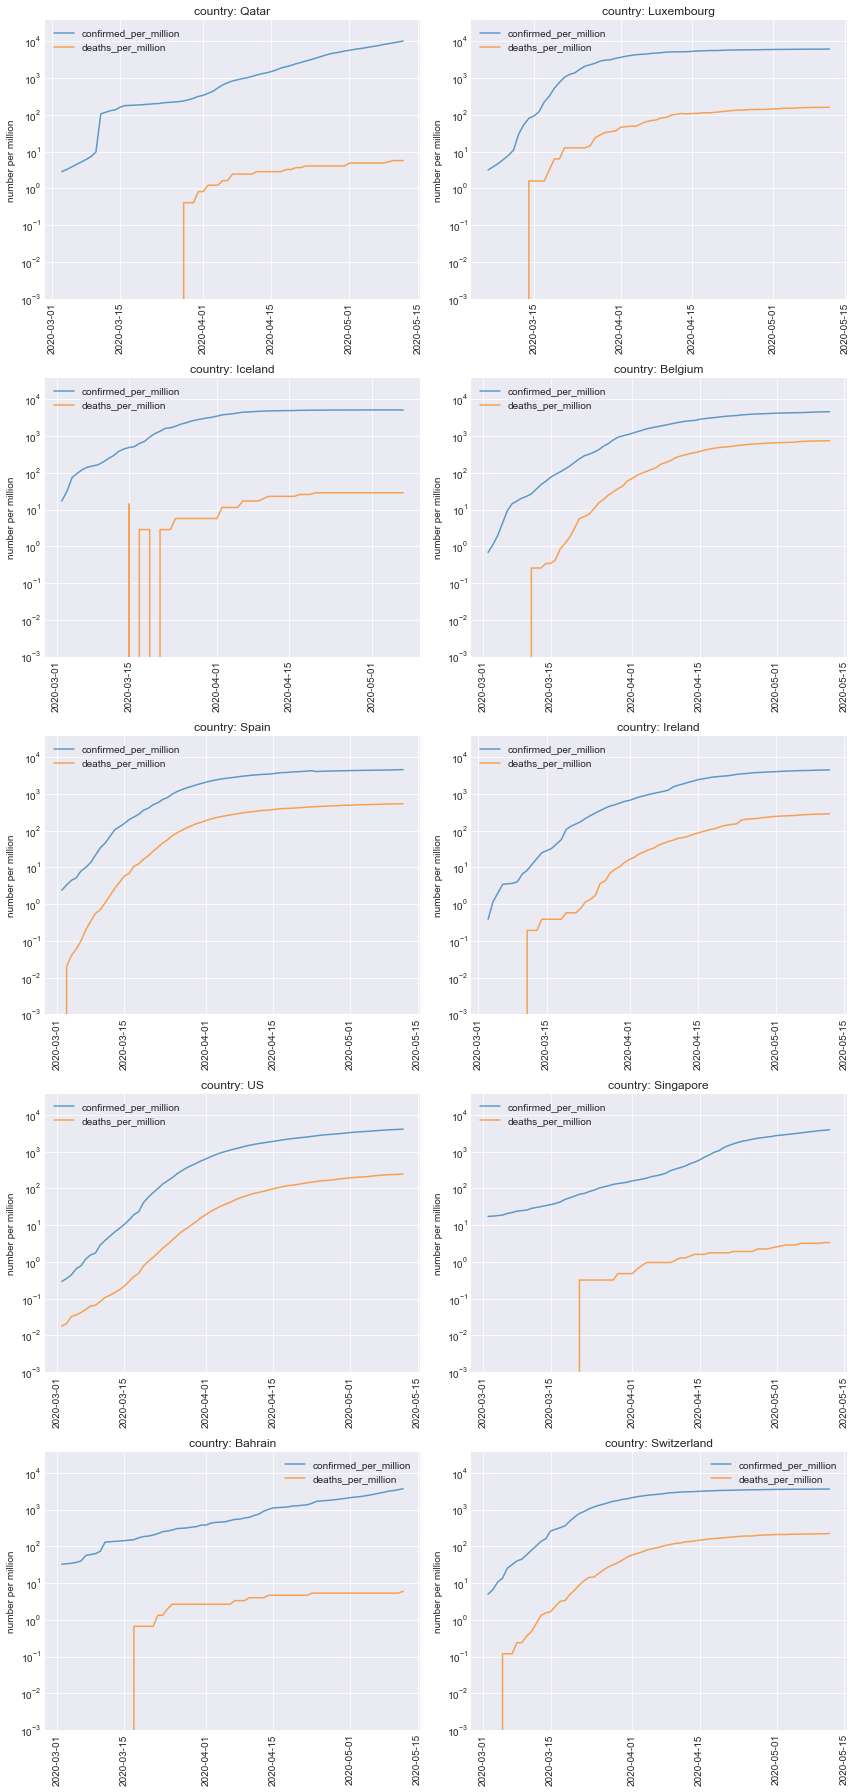

country   population  confirmed   deaths  confirmed_per_million  \
0        Qatar    2444174.0    25149.0     14.0           10289.365651   
1   Luxembourg     628381.0     3894.0    102.0            6196.877372   
2      Iceland     350734.0     1801.0     10.0            5134.945571   
3      Belgium   11720716.0    53779.0   8761.0            4588.371564   
4        Spain   50015792.0   228030.0  26920.0            4559.160035   
5      Ireland    5176569.0    23242.0   1488.0            4489.846460   
6           US  332639102.0  1369376.0  82356.0            4116.701830   
7    Singapore    6209660.0    24671.0     21.0            3973.003353   
8      Bahrain    1505003.0     5531.0      9.0            3675.075731   
9  Switzerland    8403994.0    30380.0   1867.0            3614.947845   

   deaths_per_million  mortality_rate  
0            5.727906        0.000557  
1          162.321903        0.026194  
2           28.511636        0.005552  
3          747.479932        0.162907  
4          538.230005        0.118055  
5          287.449081        0.064022  
6          247.583641        0.060141  
7            3.381828        0.000851  
8            5.980055        0.001627  
9          222.156275        0.061455

In [359]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

### Mortality rate by deaths per capita, confirmed per capita

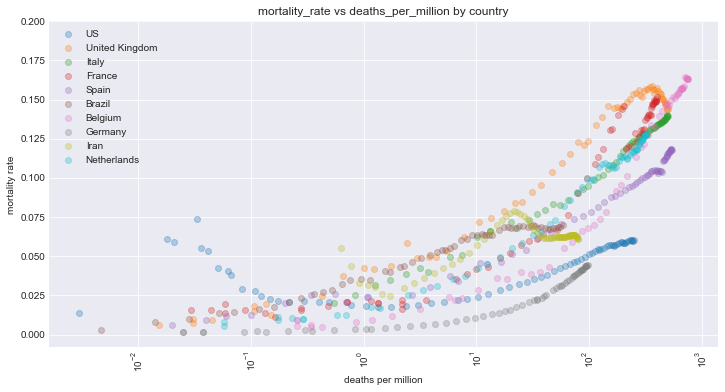

In [360]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

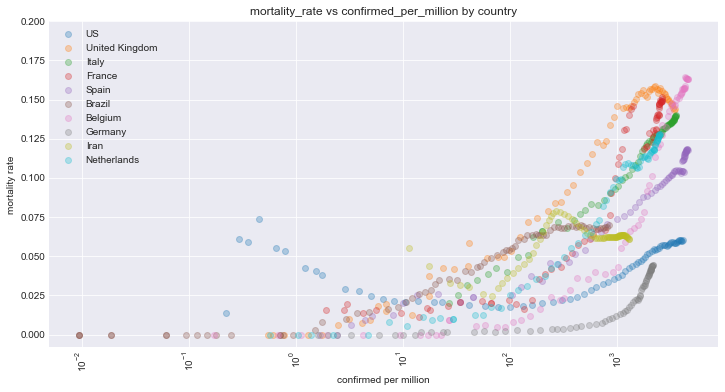

In [361]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [362]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

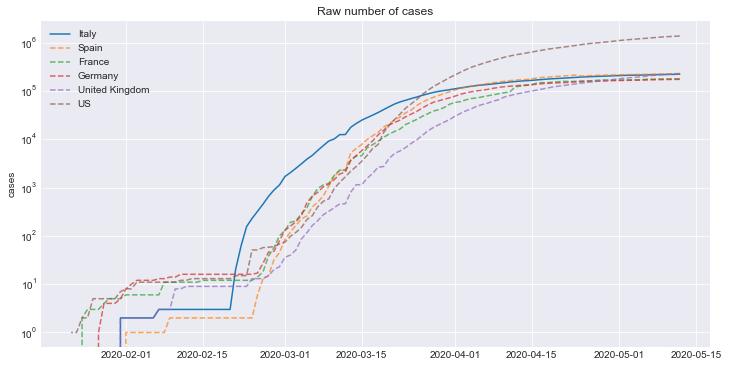

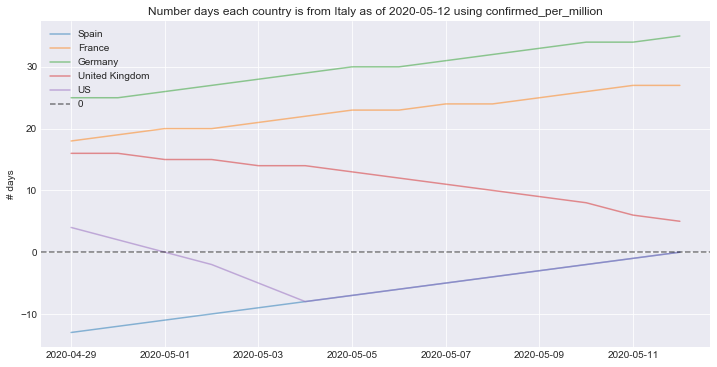

In [363]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

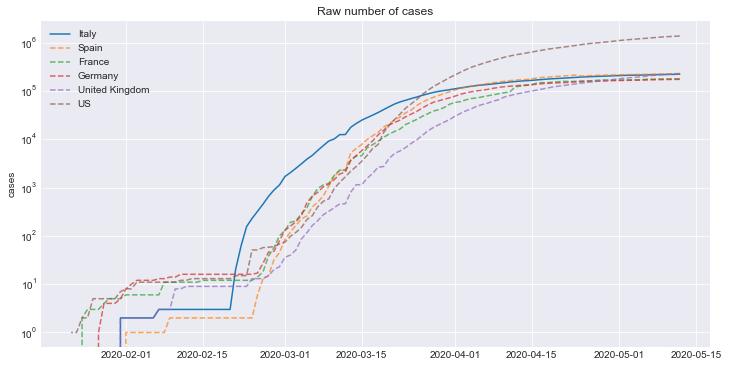

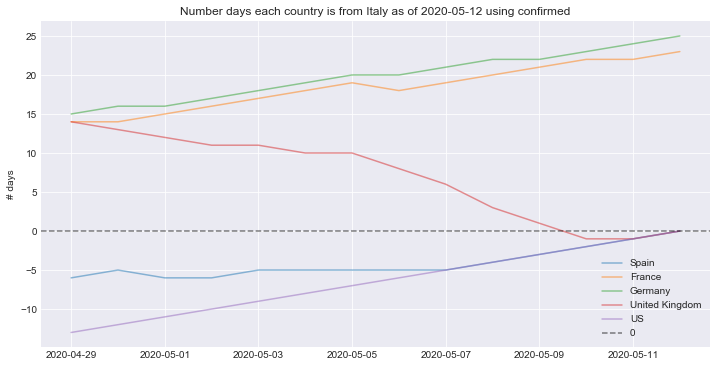

In [364]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [365]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [366]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [367]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [368]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [369]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-13       New York     338485           1430   27284         296   
1  2020-05-13     New Jersey     140917            711    9531         191   
2  2020-05-13  Massachusetts      79332            870    5141          33   
3  2020-05-13       Michigan      48021            469    4674          90   
4  2020-05-13   Pennsylvania      61310            851    3914          82   
5  2020-05-13       Illinois      83021           4014    3601         142   
6  2020-05-13    Connecticut      34333            568    3041          33   
7  2020-05-13     California      70978           1649    2879         100   
8  2020-05-13      Louisiana      32050            235    2347          39   
9  2020-05-13        Florida      41923            941    1779          44   
10 2020-05-13       Maryland      34061            688    1756          73   
11 2020-05-13        Indiana      25127            500    1578          38   
12 2020-05-13        Georgia      34924            922    1498          54   
13 2020-05-13           Ohio      25250            473    1436          79   
14 2020-05-13          Texas      41432            877    1146          29   

    mortality_rate  
0         0.080606  
1         0.067636  
2         0.064804  
3         0.097332  
4         0.063840  
5         0.043375  
6         0.088574  
7         0.040562  
8         0.073229  
9         0.042435  
10        0.051555  
11        0.062801  
12        0.042893  
13        0.056871  
14        0.027660

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [370]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

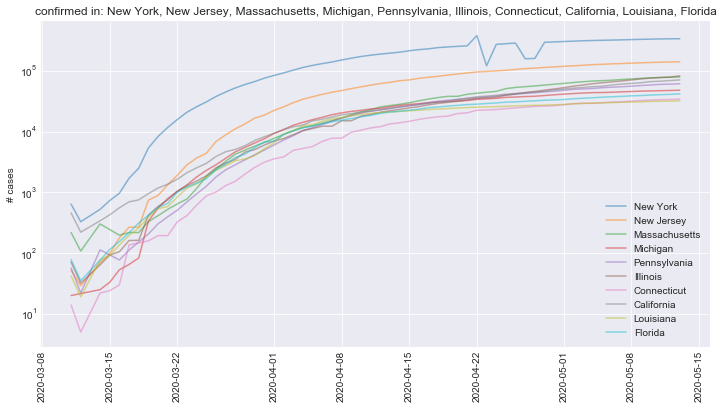

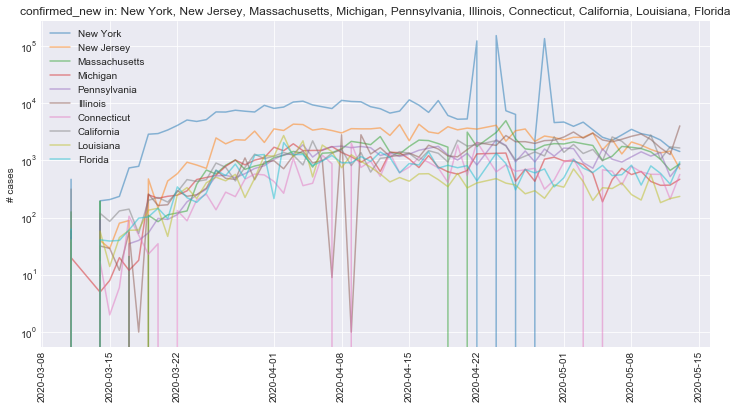

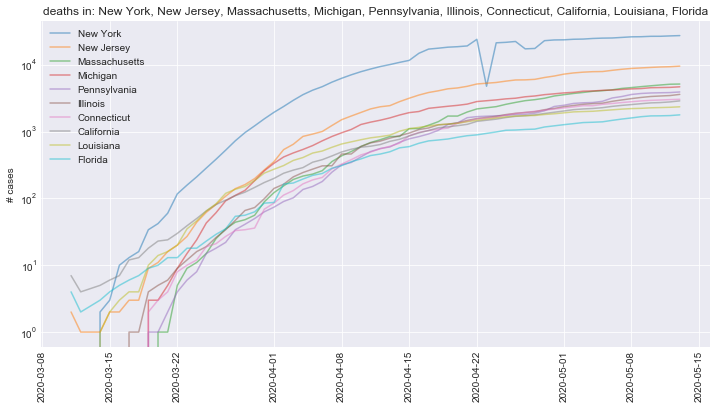

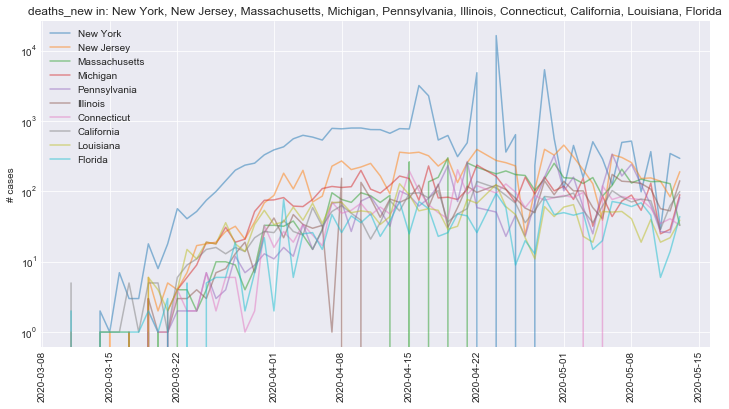

In [371]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

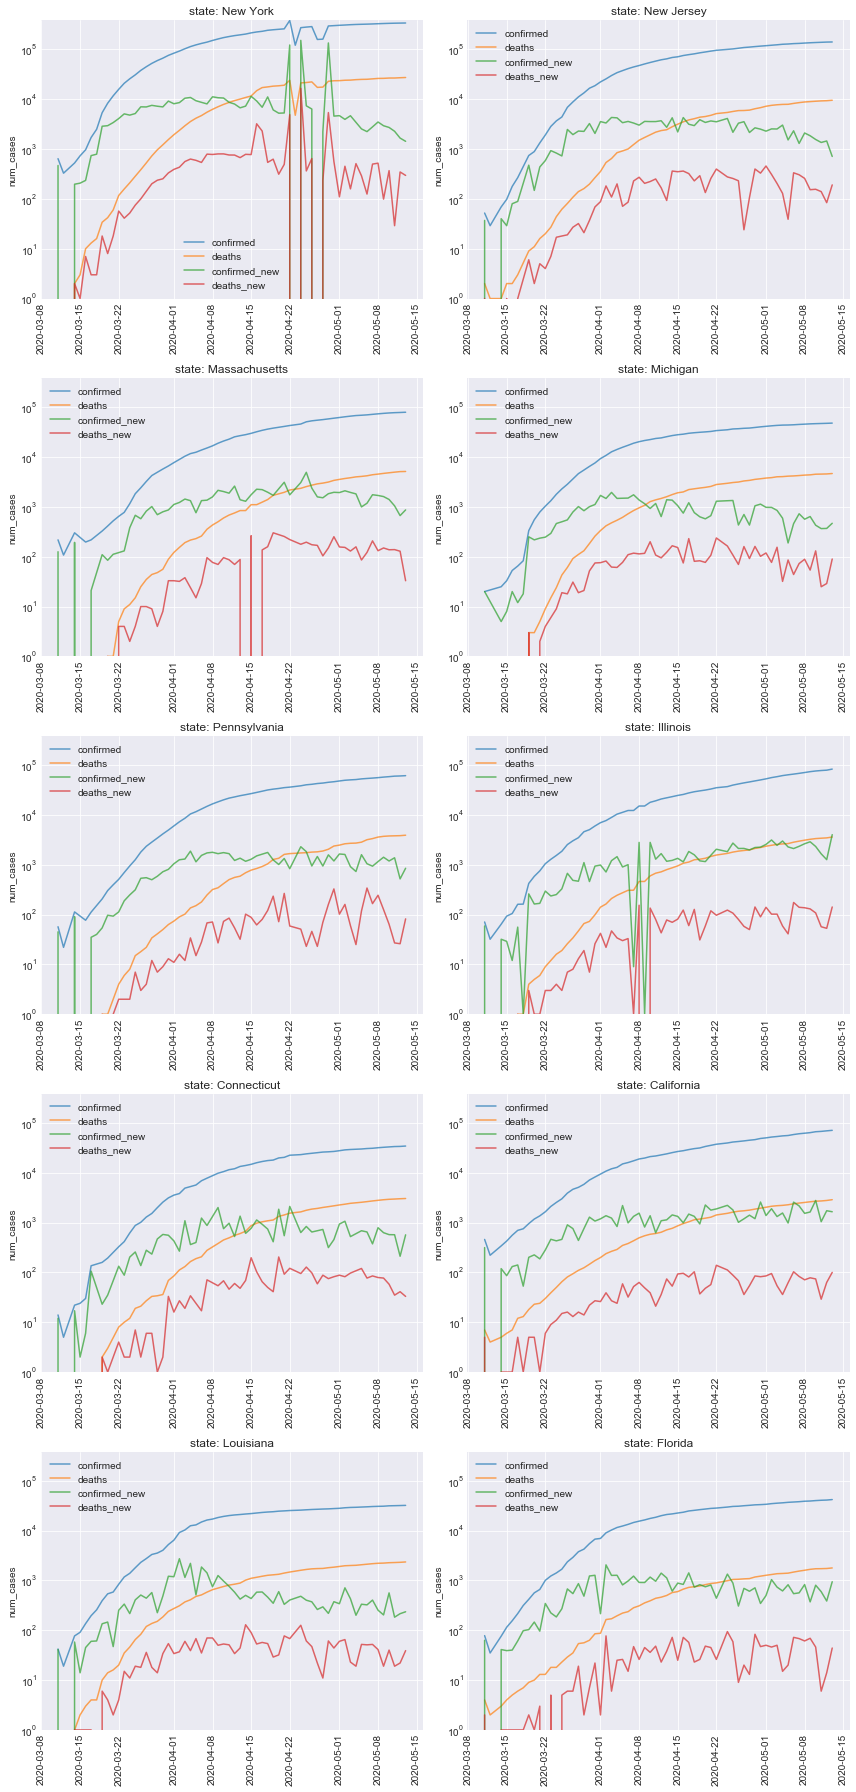

In [372]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

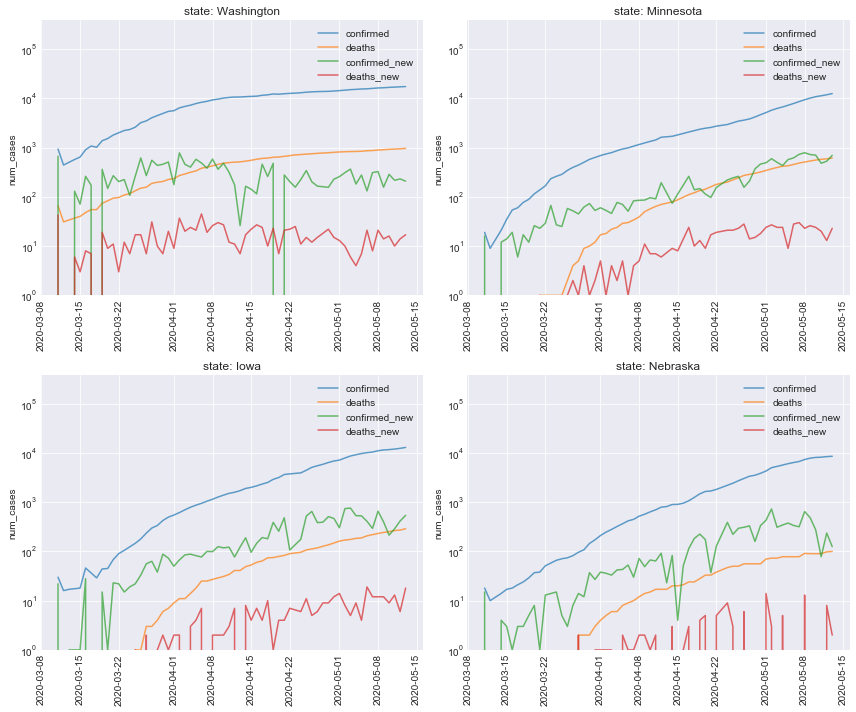

In [373]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-05-14 2020-05-20 2020-06-03  2020-05-14 2020-05-20   
state                                                                       
New York            342066.0   357359.0   395753.0     27530.0    29151.0   
New Jersey          143177.0   153028.0   178730.0      9713.0    10756.0   
Massachusetts        81179.0    89333.0   111688.0      5350.0     6271.0   
Michigan             48575.0    51552.0    59225.0      4754.0     5205.0   
Pennsylvania         62932.0    70582.0    92245.0      4054.0     4636.0   
Illinois             85223.0   102434.0   157347.0      3718.0     4447.0   
Connecticut          35054.0    38706.0    48775.0      3124.0     3488.0   
California           73203.0    85972.0   125108.0      2940.0     3408.0   
Louisiana            32418.0    34254.0    38951.0      2375.0     2562.0   
Florida              42488.0    46664.0    58077.0      1835.0     2099.0   

                         mortality_rate_pred                        \
date          2020-06-03          2020-05-14 2020-05-20 2020-06-03   
state                                                                
New York         33315.0            0.080482   0.081573   0.084181   
New Jersey       13648.0            0.067839   0.070288   0.076361   
Massachusetts     9084.0            0.065904   0.070198   0.081334   
Michigan          6431.0            0.097869   0.100966   0.108586   
Pennsylvania      6342.0            0.064419   0.065682   0.068752   
Illinois          6754.0            0.043627   0.043413   0.042924   
Connecticut       4511.0            0.089120   0.090115   0.092486   
California        4810.0            0.040162   0.039641   0.038447   
Louisiana         3058.0            0.073262   0.074794   0.078509   
Florida           2872.0            0.043189   0.044981   0.049452   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.007316             0.009582  
New Jersey                   0.011151             0.017154  
Massachusetts                0.016080             0.026819  
Michigan                     0.009961             0.015222  
Pennsylvania                 0.019303             0.022627  
Illinois                     0.031134             0.030294  
Connecticut                  0.016652             0.018533  
California                   0.027159             0.024928  
Louisiana                    0.009221             0.012727  
Florida                      0.015751             0.022662

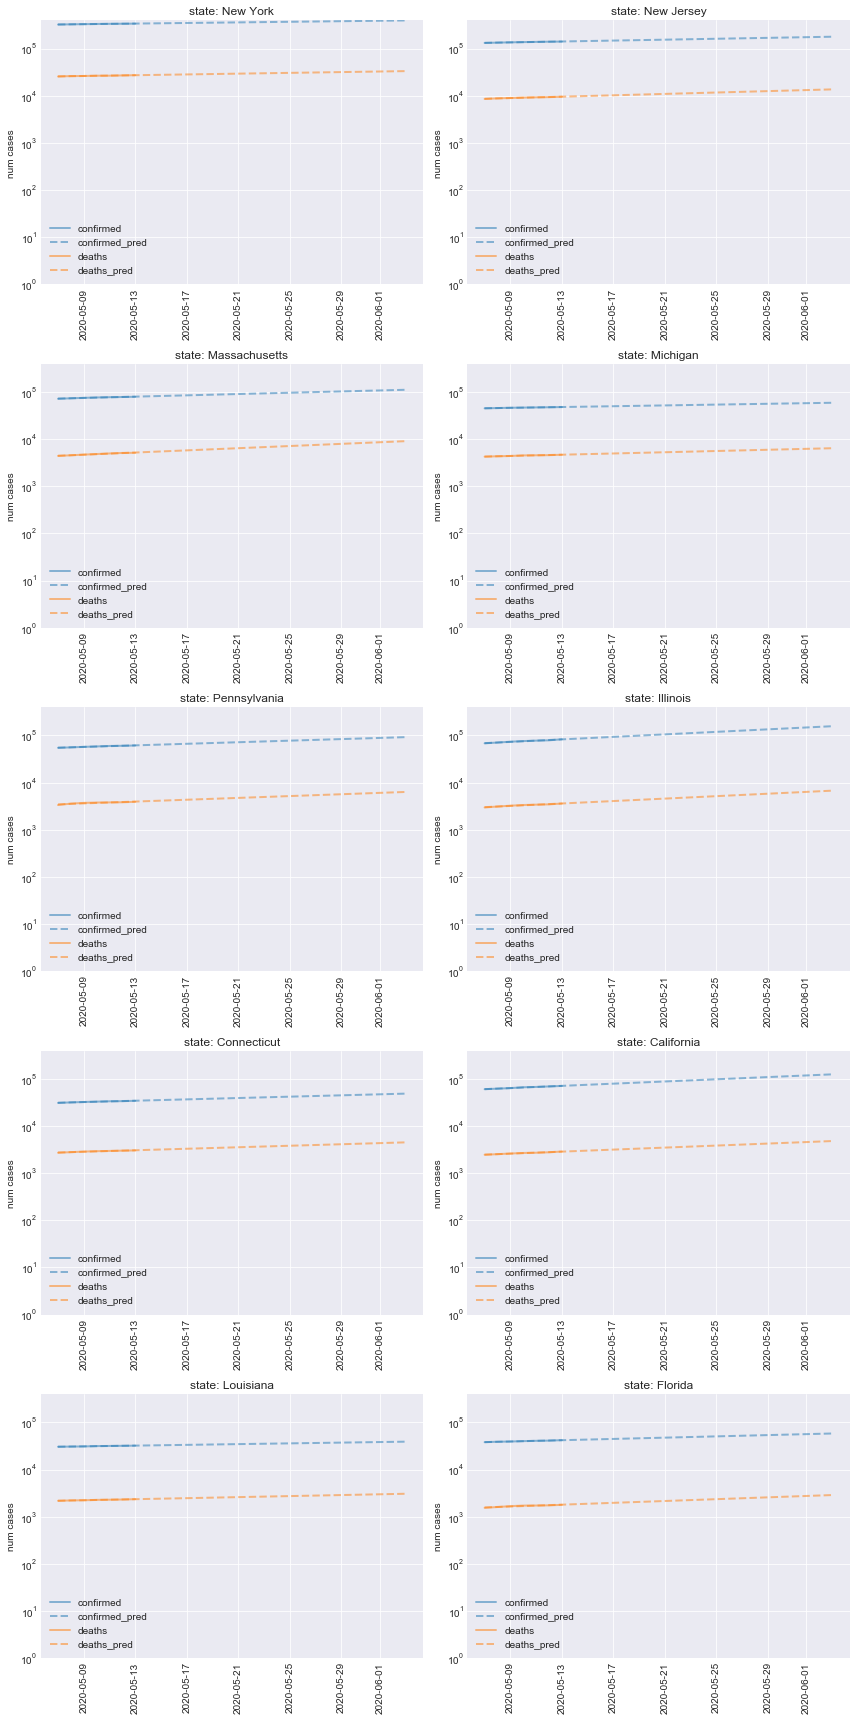

In [374]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-05-14 2020-05-20 2020-06-03  2020-05-14 2020-05-20   
state                                                                       
New York            344841.0   364493.0   414811.0     27773.0    29855.0   
New Jersey          145430.0   158999.0   195788.0      9999.0    11600.0   
Massachusetts        82852.0    94025.0   126311.0      5469.0     6643.0   
Michigan             49114.0    52969.0    63180.0      4810.0     5354.0   
Pennsylvania         63508.0    72165.0    97234.0      4342.0     5600.0   
Illinois             87581.0   109518.0   184501.0      3814.0     4769.0   
Connecticut          35318.0    39417.0    50929.0      3222.0     3781.0   
California           73888.0    88240.0   133519.0      2992.0     3569.0   
Louisiana            32684.0    34944.0    40846.0      2423.0     2700.0   
Florida              42857.0    47638.0    60975.0      1884.0     2260.0   

                         mortality_rate_pred                        \
date          2020-06-03          2020-05-14 2020-05-20 2020-06-03   
state                                                                
New York         35340.0            0.080539   0.081908   0.085195   
New Jersey       16404.0            0.068755   0.072956   0.083785   
Massachusetts    10454.0            0.066009   0.070651   0.082764   
Michigan          6874.0            0.097935   0.101078   0.108800   
Pennsylvania     10144.0            0.068369   0.077600   0.104326   
Illinois          8036.0            0.043548   0.043545   0.043555   
Connecticut       5489.0            0.091228   0.095923   0.107777   
California        5389.0            0.040494   0.040447   0.040361   
Louisiana         3477.0            0.074134   0.077266   0.085125   
Florida           3457.0            0.043960   0.047441   0.056695   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.009280             0.012120  
New Jersey                   0.014978             0.025062  
Massachusetts                0.021308             0.032918  
Michigan                     0.012671             0.018011  
Pennsylvania                 0.021525             0.043338  
Illinois                     0.037957             0.037968  
Connecticut                  0.018471             0.026993  
California                   0.030027             0.029861  
Louisiana                    0.011209             0.018217  
Florida                      0.017786             0.030812

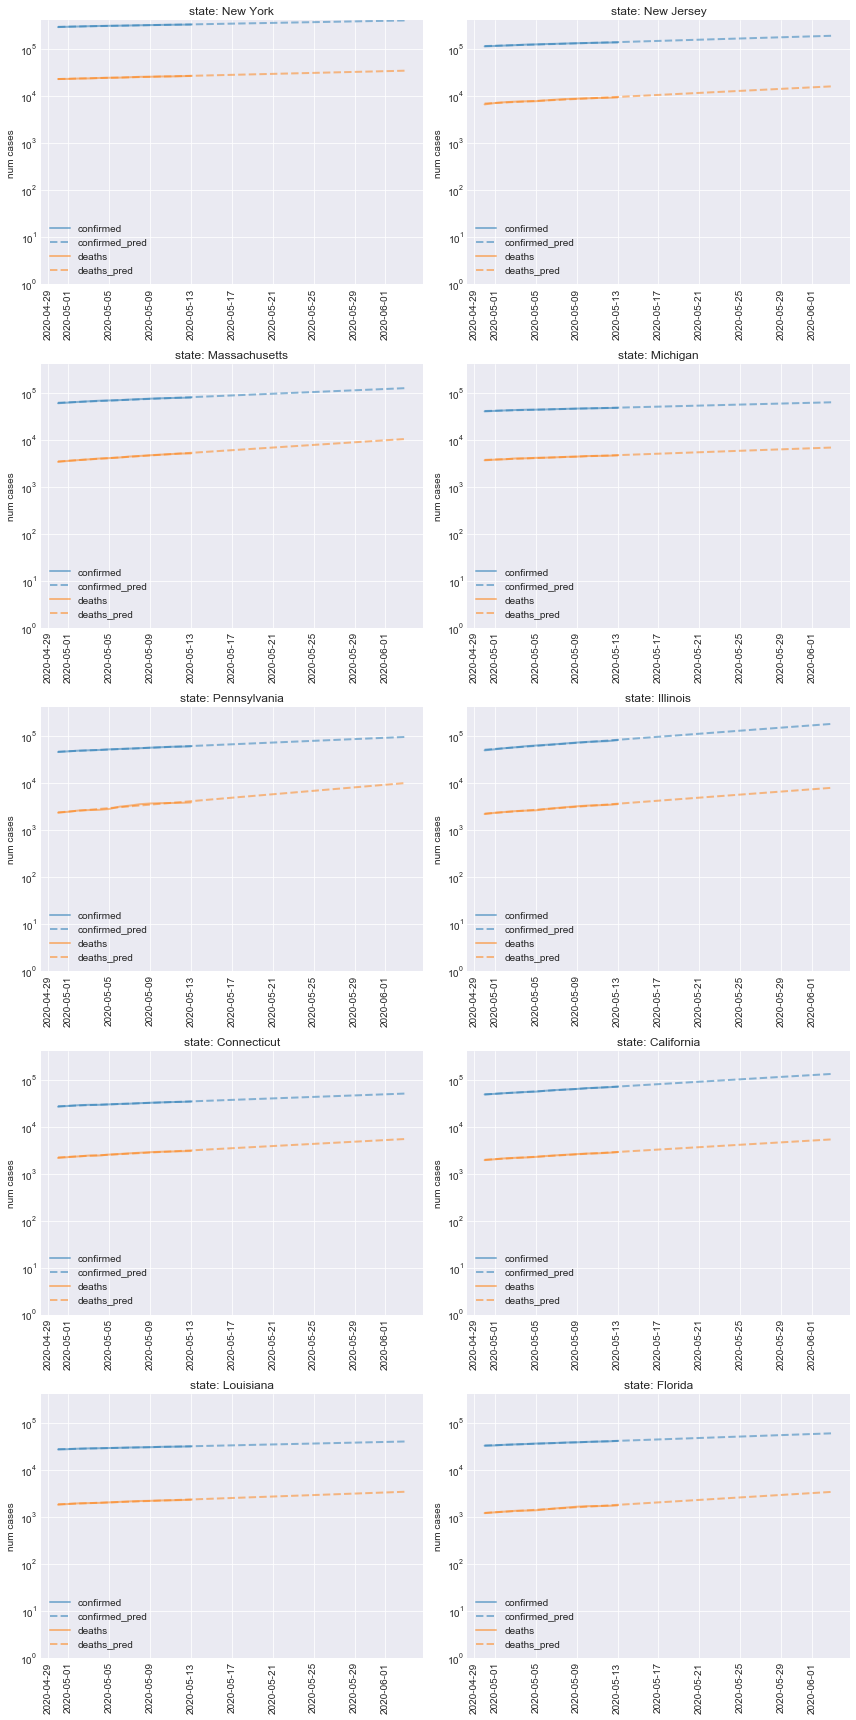

In [375]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [376]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [377]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-05-13         New Hampshire       3239     142           9   
1  2020-05-13        Virgin Islands         69       6           1   
2  2020-05-13            New Mexico       5212     219          11   
3  2020-05-13                  Iowa      12912     289          18   
4  2020-05-13               Arizona      11736     562          20   
5  2020-05-13          South Dakota       3663      39           5   
6  2020-05-13             Minnesota      12494     614          23   
7  2020-05-13                  Utah       6432      73           5   
8  2020-05-13          North Dakota       1571      38           2   
9  2020-05-13              Missouri      10269     529          15   
10 2020-05-13  District of Columbia       6485     336           8   
11 2020-05-13               Alabama      10464     435          32   
12 2020-05-13              Virginia      25800     892          42   
13 2020-05-13        North Carolina      15622     600          25   
14 2020-05-13              Delaware       6741     237          12   
15 2020-05-13              Maryland      34061    1756          73   
16 2020-05-13              Nebraska       8532     100           2   
17 2020-05-13                 Texas      41432    1146          29   
18 2020-05-13           Mississippi       9908     457          22   
19 2020-05-13              Illinois      83021    3601         142   
20 2020-05-13          Rhode Island      11614     444          14   
21 2020-05-13         Massachusetts      79332    5141          33   
22 2020-05-13            California      70978    2879         100   
23 2020-05-13        South Carolina       7927     355           9   
24 2020-05-13           Puerto Rico       2299     114           1   
25 2020-05-13             Wisconsin      10611     418           9   
26 2020-05-13               Florida      41923    1779          44   
27 2020-05-13                  Ohio      25250    1436          79   
28 2020-05-13          Pennsylvania      61310    3914          82   
29 2020-05-13         West Virginia       1378      58           4   
30 2020-05-13               Indiana      25127    1578          38   
31 2020-05-13                Kansas       7240     184           4   
32 2020-05-13           Connecticut      34333    3041          33   
33 2020-05-13                Oregon       3358     130           0   
34 2020-05-13              Kentucky       6853     321          10   
35 2020-05-13               Georgia      34924    1498          54   
36 2020-05-13                Nevada       6313     321           9   
37 2020-05-13            New Jersey     140917    9531         191   
38 2020-05-13              Arkansas       4164      95           1   
39 2020-05-13            Washington      17330     962          17   
40 2020-05-13             Tennessee      16111     266          15   
41 2020-05-13              Michigan      48021    4674          90   
42 2020-05-13              Oklahoma       4732     278           4   
43 2020-05-13              Colorado      20157    1010          23   
44 2020-05-13             Louisiana      32050    2347          39   
45 2020-05-13              New York     338485   27284         296   
46 2020-05-13                 Maine       1477      65           0   
47 2020-05-13                 Idaho       2293      69          -1   
48 2020-05-13               Vermont        927      53           0   
49 2020-05-13                  Guam        152       5           0   
50 2020-05-13                Alaska        383      10           0   
51 2020-05-13                Hawaii        635      17           0   
52 2020-05-13               Montana        461      16           0   
53 2020-05-13        Grand Princess        103       3           0   
54 2020-05-13               Wyoming        675       7           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.027         

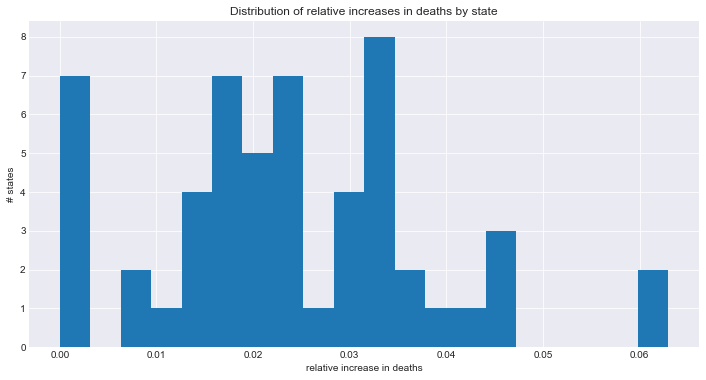

In [378]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

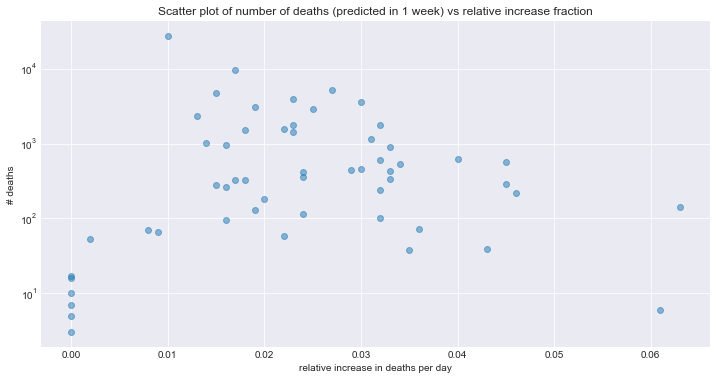

In [379]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [380]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

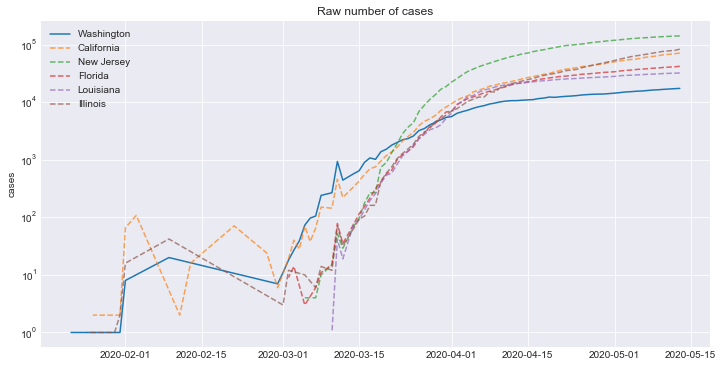

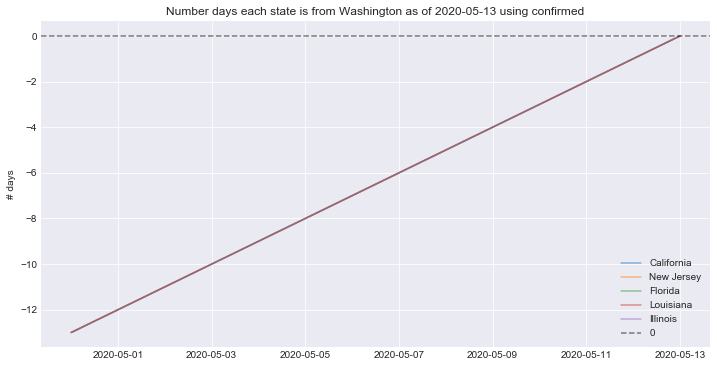

In [381]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

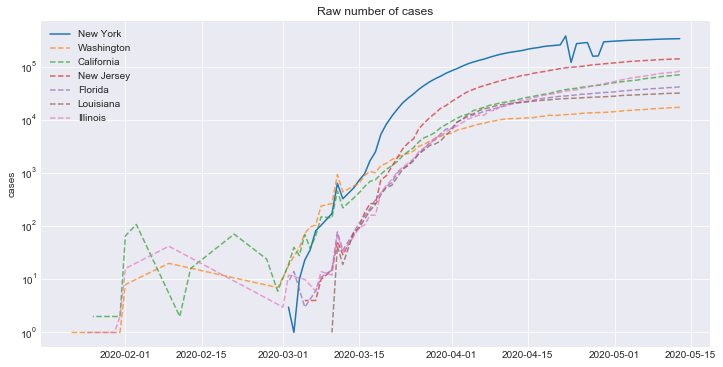

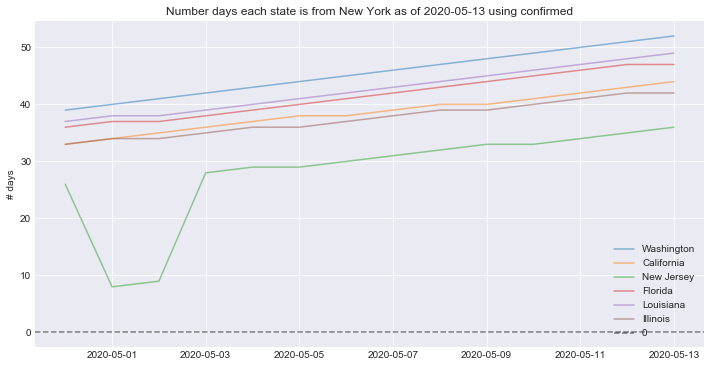

In [382]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

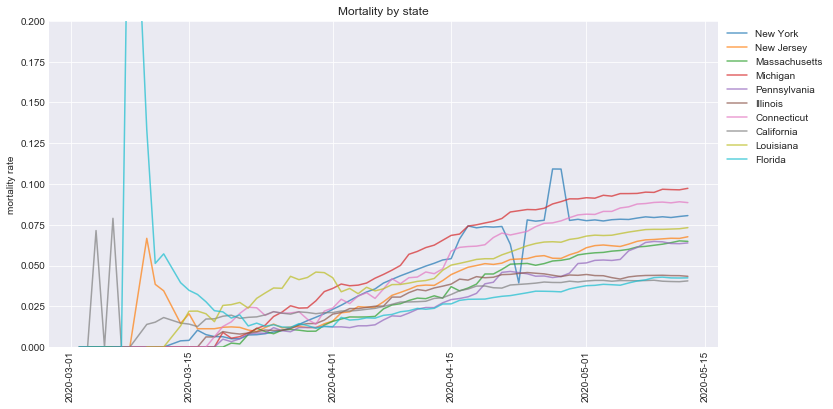

In [383]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

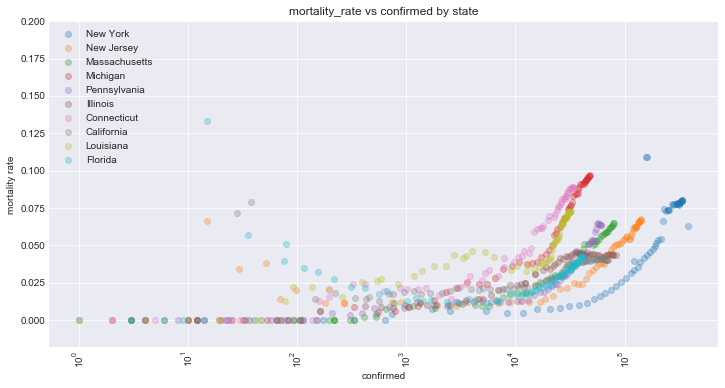

In [384]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

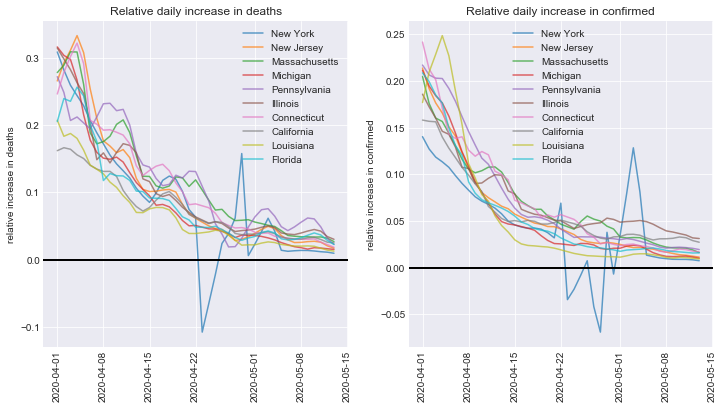

In [385]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [386]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={'deaths_new'})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest['deaths_new_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [387]:
n_days_training = 21
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )

confirmed_new_pred                                              \
date                  2020-05-14 2020-05-20 2020-05-27 2020-06-10 2020-07-08   
state                                                                          
Illinois                    2396       2436       2483       2580       2786   
California                  1722       1794       1882       2070       2506   
New York                    1414        743        351         78          3   
New Jersey                  1167        836        567        260         54   
Massachusetts                895        630        419        185         36   
Pennsylvania                 870        727        590        388        167   
Florida                      587        561        532        479        388   
Connecticut                  475        419        363        272        153   
Michigan                     377        282        201        102         26   
Louisiana                    249        217        185        134         70   

                                                                      \
date          2020-08-05 2020-09-02 2020-09-30 2020-10-28 2020-12-23   
state                                                                  
Illinois            3008       3248       3506       3786       4413   
California          3033       3671       4443       5377       7876   
New York               0          0          0          0          0   
New Jersey            11          2          0          0          0   
Massachusetts          7          1          0          0          0   
Pennsylvania          72         31         13          5          1   
Florida              314        254        206        167        109   
Connecticut           86         48         27         15          4   
Michigan               6          1          0          0          0   
Louisiana             37         19         10          5          1   

              deaths_new_pred                                              \
date               2020-05-14 2020-05-20 2020-05-27 2020-06-10 2020-07-08   
state                                                                       
Illinois                   97         99        102        107        119   
California                 63         61         58         52         43   
New York                  126         69         34          8          0   
New Jersey                155        143        130        108         74   
Massachusetts              96         78         61         37         14   
Pennsylvania               96        108        125        164        285   
Florida                    30         27         25         20         14   
Connecticut                48         37         27         15          4   
Michigan                   46         33         22         10          2   
Louisiana                  26         21         17         10          4   

                                                                      \
date          2020-08-05 2020-09-02 2020-09-30 2020-10-28 2020-12-23   
state                                                                  
Illinois             132        146        162        180        221   
California            35         28         23         19         13   
New York               0          0          0          0          0   
New Jersey            51         35         24         16          7   
Massachusetts          5          2          0          0          0   
Pennsylvania         496        861       1494       2593       7808   
Florida                9          6          4          3          1   
Connecticut            1          0          0          0          0   
Michigan               0          0          0          0          0   
Louisiana              1          0          0          0          0   

              frac_increase_confirmed frac_increase_deaths  
date                                

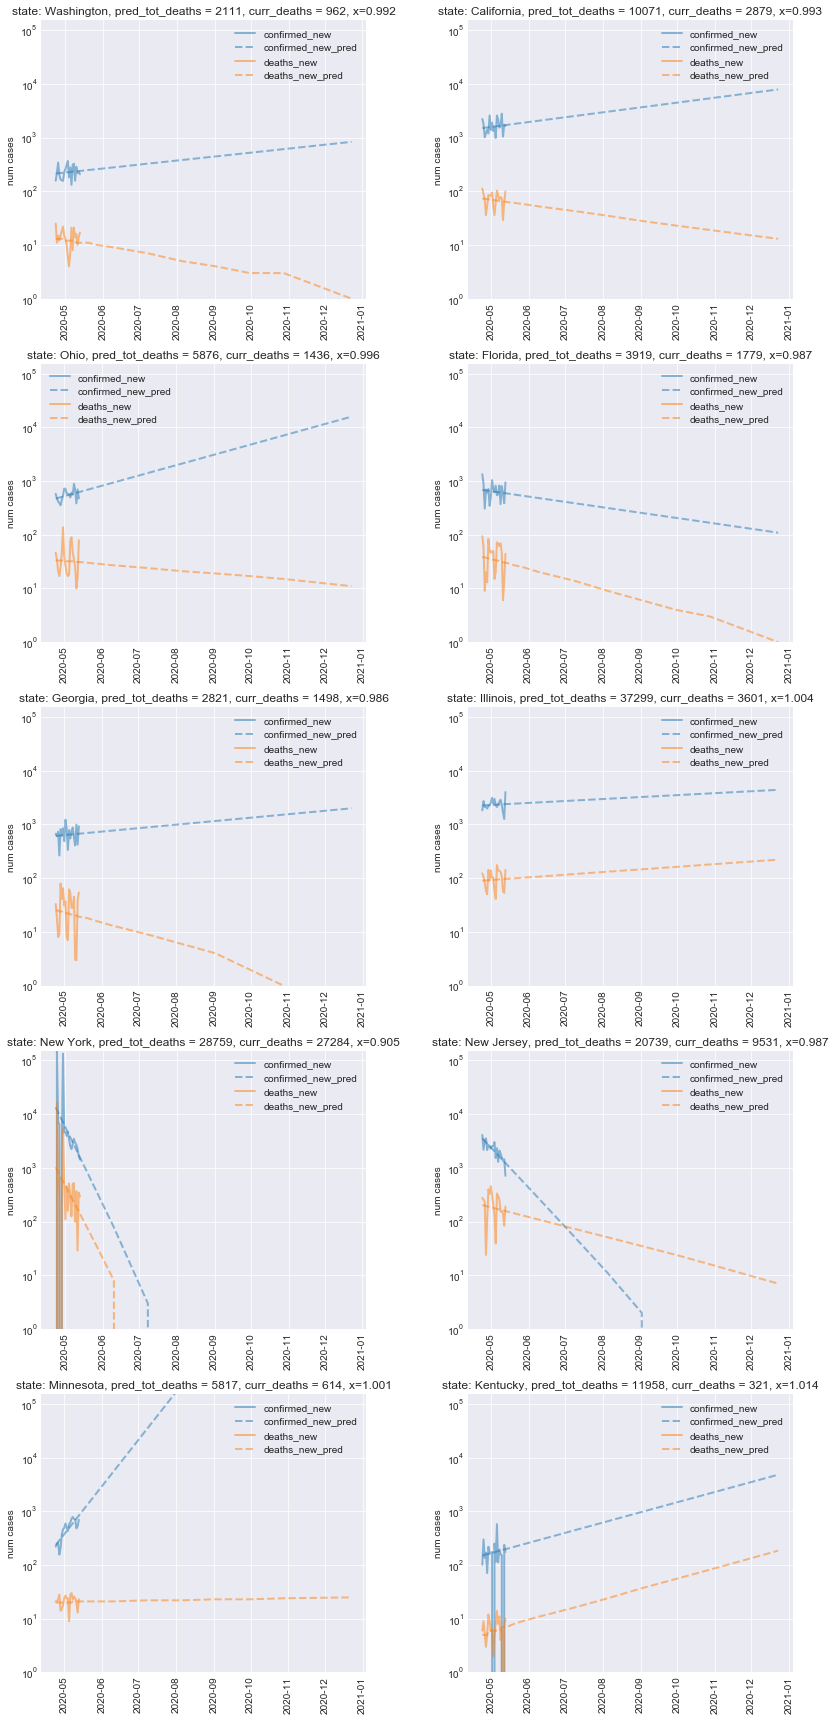

In [388]:
plot_forecasts_new(dfp_us_recent_1, col_locale='state', top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky'])

In [389]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-05-13_n_days_training=21.csv


### Which states are increasing in new deaths <u>most</u> quickly?

In [390]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0    Mississippi              0.041013                -0.006362
1           Iowa              0.027408                -0.002292
2  New Hampshire              0.025660                 0.008486
3        Arizona              0.020214                 0.013575
4      Tennessee              0.019960                -0.020195
5   Pennsylvania              0.019881                -0.029476
6        Alabama              0.018360                 0.020087
7       Kentucky              0.014489                 0.014347
8       Missouri              0.013750                -0.021360
9          Texas              0.013129                 0.016615

### Which states are increasing in new deaths <u>least</u> quickly?

In [391]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48               Georgia             -0.013707                 0.004875
49  District of Columbia             -0.018330                 0.007748
50           Puerto Rico             -0.031485                -0.003649
51             Louisiana             -0.032178                -0.022620
52         Massachusetts             -0.034295                -0.056625
53           Connecticut             -0.040909                -0.020352
54              Oklahoma             -0.041866                -0.006950
55              Colorado             -0.043103                -0.033315
56              Michigan             -0.052379                -0.047040
57              New York             -0.094903                -0.101618

### Is there a day-of-the-week effect on new deaths?

In [392]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [393]:
dfp_us_dow['death_delta'] = dfp_us_dow['deaths_new']- dfp_us_dow['deaths_new_pred']
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow['deaths_new_pred']

dfp_us_dow['confirmed_delta'] = dfp_us_dow['confirmed_new']- dfp_us_dow['confirmed_new_pred']
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow['confirmed_new_pred']
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.median, 
                          'deaths_new': np.mean, 
                          'deaths_new_pred': np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.median})
                    )

In [394]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -2.333333        -0.090909    9.666667   
379  Washington    1    -1.000000        -0.071970   10.500000   
380  Washington    2     8.000000         0.692308   20.000000   
381  Washington    3     3.666667         0.250000   16.000000   
382  Washington    4     2.666667         0.083333   15.000000   
383  Washington    5     0.666667         0.153846   13.000000   
384  Washington    6    -0.666667        -0.076923   11.333333   

     deaths_new_pred  confirmed_delta  confirmed_rel_delta  
378        12.000000       -39.333333            -0.198238  
379        11.500000        20.500000             0.090098  
380        12.000000       -64.666667            -0.294118  
381        12.333333         9.666667             0.027027  
382        12.333333        45.000000             0.147321  
383        12.333333        44.666667             0.377778  
384        12.000000        58.666667             0.217021

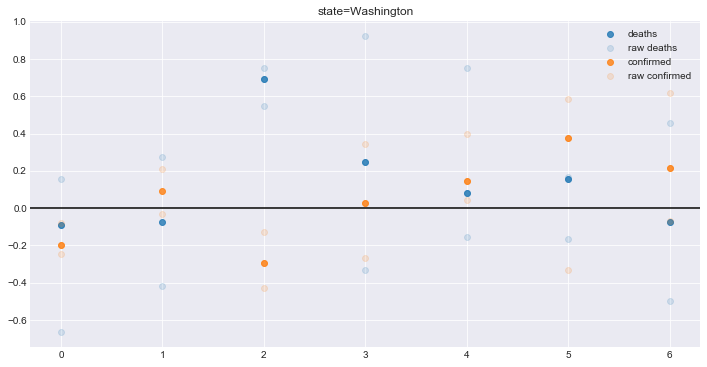

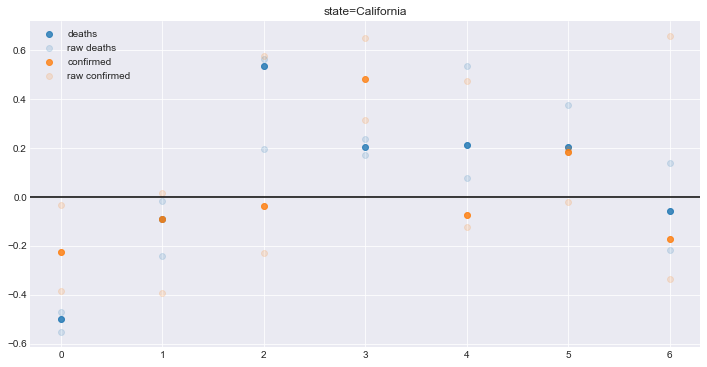

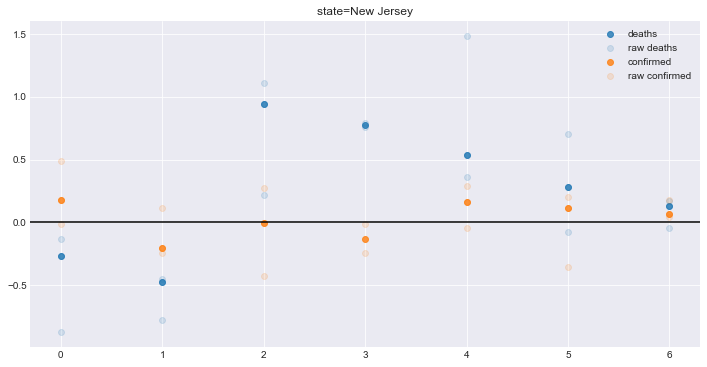

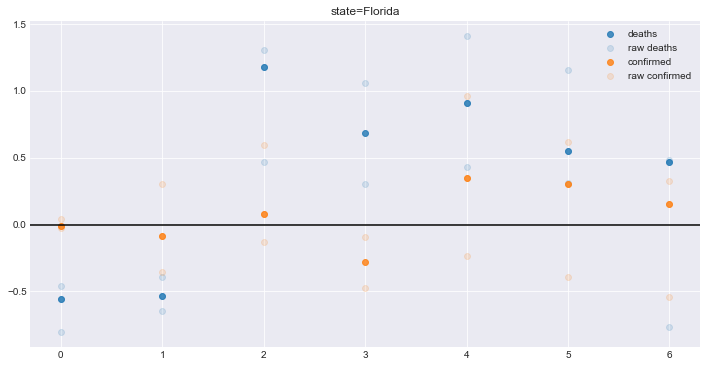

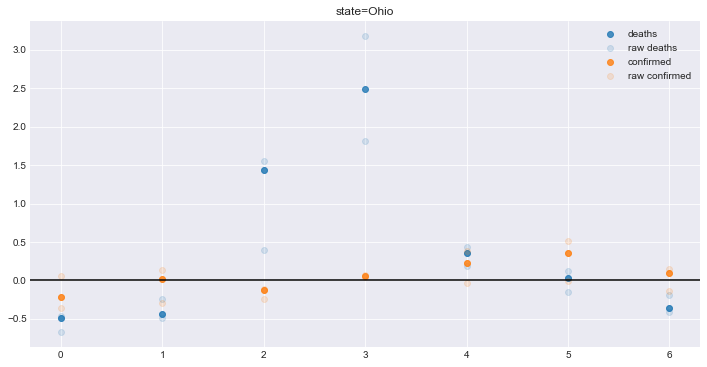

In [395]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()